#**NATURAL IMAGE CLASSIFIER USING CNN AND VGG16**

##**MOUNT GOOGLE DRIVE**

In [75]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
cd /content/drive/MyDrive/natural_images\ 

/content/drive/MyDrive/natural_images 


##**IMPORTING LIBRARIES**

In [77]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import random
import cv2
import os
from PIL import Image

from keras.layers import *
from keras.models import *
import keras
import tensorflow as tf

## **ABOUT THE DATA**

The training and validation dataset has been taken from [Kaggle](https://www.kaggle.com/prasunroy/natural-images).

This dataset contains 6,899 images from 8 distinct classes compiled from various sources (see Acknowledgements). The classes include airplane, car, cat, dog, flower, fruit, motorbike and person.

* Airplane: 727 images
* Car: 968 images
* Cat: 885 images
* Dog: 702 images
* Flower: 843 images
* Fruit: 1000 images
* Motorbike: 788 images
* Person: 986 images

For obtaining training and validation images from each class were roughly divided into two parts of 80:20 for training and validation respectively.
Finally 5522 images were obtained in training set and 1377 in validation set.

Finally for testing purpose we have obtained the data from webscarping images. We have collected 20 images for each class for testing purpose hence the total size of test set is 180.

### **Storing the path of data into variables**

In [78]:
train_dir = r'./train'  # Location of training images
validation_dir = r'./validate' #Location of test images
test_dir =r'./test' #Location of test images

###**DATA PREPROESSING**
#### Read the images.
  * Decode the JPEG content to RBG grids of pixels.
  * Convert these into floating point tensors.
  * Rescale the pixel values (between 0 and 255) to the [0, 1] interval

#### Data Augmentation
Data augmentation is a strategy that enables practitioners to significantly increase the diversity of data available for training models, without actually collecting new data. Data augmentation techniques such as cropping, padding, and horizontal flipping are commonly used to train large neural networks.

Here we would be using the ImageDataGenrator from keras to perform various operations on my training images like shear, rescale, rotate etc. For more information visit the Keras official documentation. The need to do augmentation is to create diversity in the data, now the model is trained to identify a rotated cat as a cat and not some other object, thereby increasing the performance of the model!!

In [79]:
# Generating batches of tensor image data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

Found 6899 images belonging to 8 classes.
Found 704 images belonging to 8 classes.


**Note: The method which is used just performs data augmentation and feeds the images to the model, for every batch it performs the given operations randomly on the images and feeds the batch of images to the model, overall 5522 images are only being fed, no new data is generated. For saving the augmented images you have to use the save_to_dir attribute and then add those data to your train folder so now you will have more images! For more information visit the Keras official documentation.**



###**PLOTTING TRAIN IMAGES WITH THEIR LABELS**

In [80]:
def plots(ims, figsize=(16,16), rows=4, interp=False, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        sp.set_title(class_names[titles[i].tolist().index(1)], fontsize=16)
        plt.imshow(ims[i])

In [81]:
class_names = ['airplane','car','cat','dog','flower','fruit','motorbike','person'] #Creating a dictionary of class names according to the label

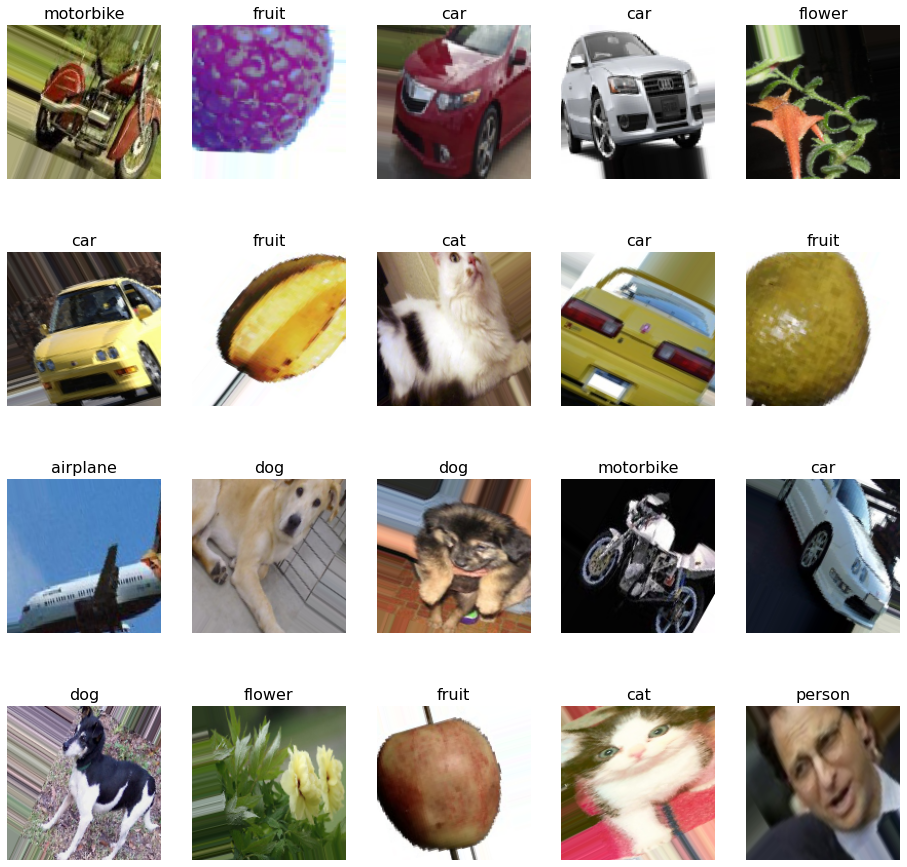

In [82]:
imgs, labels = next(train_generator)
plots(imgs, titles=labels)
plt.savefig('train_images.png')

## **I. CNN MODEL ARCHITECTURE**

In [83]:
from keras import models, layers
model = models.Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(8, activation='softmax'))

In [84]:
#Plotting a graphical representation of the model
import keras
import pydotplus
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import plot_model

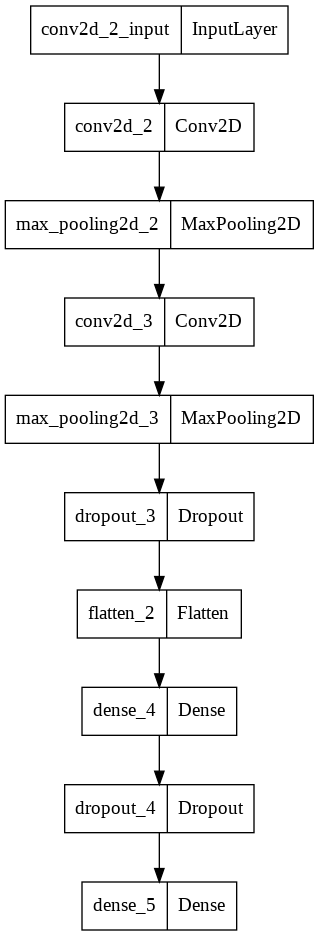

In [85]:
plot_model(model)

In [86]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 146, 146, 32)      2432      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 35, 35, 64)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 35, 35, 64)        0         
                                                                 
 flatten_2 (Flatten)         (None, 78400)            

In [87]:
from tensorflow.keras import optimizers
model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam',
    metrics=['accuracy']  
)

## **TRAINING**

In [88]:

from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))




epochs = 10
## save the model found in each iteration
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("model_save_at_{epoch}.h5"),
]
model.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=["categorical_accuracy",f1_m, precision_m, recall_m],
)
## Train the model and get the history

history_train = model.fit_generator(
    train_generator, epochs=epochs, callbacks=callbacks,
    validation_data=val_generator
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/10
345/345 [==============================] - 83s 237ms/step - loss: 1.3440 - categorical_accuracy: 0.5275 - f1_m: 0.4437 - precision_m: 0.6924 - recall_m: 0.3460 - val_loss: 0.6095 - val_categorical_accuracy: 0.7955 - val_f1_m: 0.7757 - val_precision_m: 0.9247 - val_recall_m: 0.6722
Epoch 2/10
345/345 [==============================] - 77s 223ms/step - loss: 0.8641 - categorical_accuracy: 0.6946 - f1_m: 0.6686 - precision_m: 0.8125 - recall_m: 0.5740 - val_loss: 0.4365 - val_categorical_accuracy: 0.8679 - val_f1_m: 0.8418 - val_precision_m: 0.9567 - val_recall_m: 0.7569
Epoch 3/10
345/345 [==============================] - 76s 219ms/step - loss: 0.7674 - categorical_accuracy: 0.7223 - f1_m: 0.7023 - precision_m: 0.8210 - recall_m: 0.6185 - val_loss: 0.3326 - val_categorical_accuracy: 0.8892 - val_f1_m: 0.8820 - val_precision_m: 0.9452 - val_recall_m: 0.8292
Epoch 4/10
345/345 [==============================] - 77s 222ms/step - loss: 0.7010 - categorical_accuracy: 0.7488 - f1_m

In [89]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=276, #data_size//batch_size = 5522//20
      epochs=15,
      validation_data=val_generator,
      validation_steps=66) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/15
276/276 [==============================] - 62s 226ms/step - loss: 0.5186 - categorical_accuracy: 0.8184 - f1_m: 0.8090 - precision_m: 0.8752 - recall_m: 0.7548 - val_loss: 0.2783 - val_categorical_accuracy: 0.9176 - val_f1_m: 0.9133 - val_precision_m: 0.9435 - val_recall_m: 0.8861
Epoch 2/15
276/276 [==============================] - 56s 203ms/step - loss: 0.5142 - categorical_accuracy: 0.8123 - f1_m: 0.8077 - precision_m: 0.8707 - recall_m: 0.7559
Epoch 3/15
276/276 [==============================] - 55s 201ms/step - loss: 0.4949 - categorical_accuracy: 0.8253 - f1_m: 0.8246 - precision_m: 0.8804 - recall_m: 0.7780
Epoch 4/15
276/276 [==============================] - 55s 200ms/step - loss: 0.5051 - categorical_accuracy: 0.8261 - f1_m: 0.8195 - precision_m: 0.8792 - recall_m: 0.7701
Epoch 5/15
276/276 [==============================] - 56s 204ms/step - loss: 0.5046 - categorical_accuracy: 0.8235 - f1_m: 0.8164 - precision_m: 0.8728 - recall_m: 0.7699
Epoch 6/15
276/276 [===

##**After training:**
* Training accuracy: 84.54%

In [90]:
model.save("model.h5") 

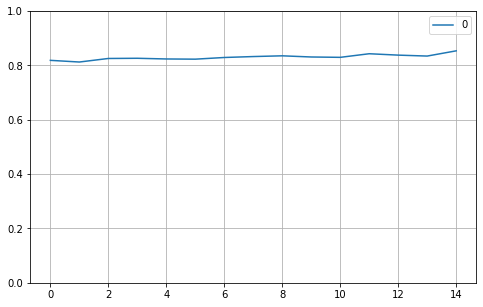

In [91]:
pd.DataFrame(history.history['categorical_accuracy']).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

As we can see although we have acheived a high accuracy the model doesnt genralize well and hence would perform porrly on training data. Even the loss is a bit high.
To increase the performance we will be using transfer learning using VGG16.

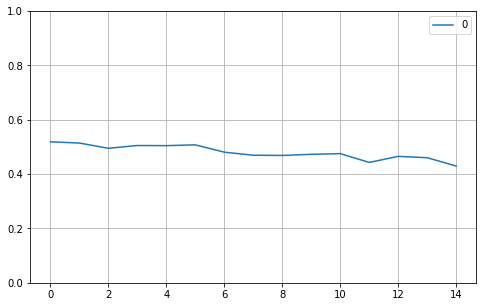

In [92]:
pd.DataFrame(history.history['loss']).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

### **LOADING THE MODEL**

## **TESTING**

In [93]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

Found 1361 images belonging to 8 classes.


In [94]:
eval = model.evaluate(test_generator, steps=20)

20/20 [==============================] - 14s 706ms/step - loss: 0.2805 - categorical_accuracy: 0.8925 - f1_m: 0.8867 - precision_m: 0.9134 - recall_m: 0.8625


In [95]:
eval = model.evaluate(test_generator, steps=15)

15/15 [==============================] - 8s 559ms/step - loss: 0.2473 - categorical_accuracy: 0.9133 - f1_m: 0.9068 - precision_m: 0.9295 - recall_m: 0.8867


In [96]:
eval = model.evaluate(test_generator, steps=9)

9/9 [==============================] - 5s 588ms/step - loss: 0.3067 - categorical_accuracy: 0.9000 - f1_m: 0.8825 - precision_m: 0.9127 - recall_m: 0.8556


**As we can see we have acheived a testing accuracy of 90.67% on unseen data**

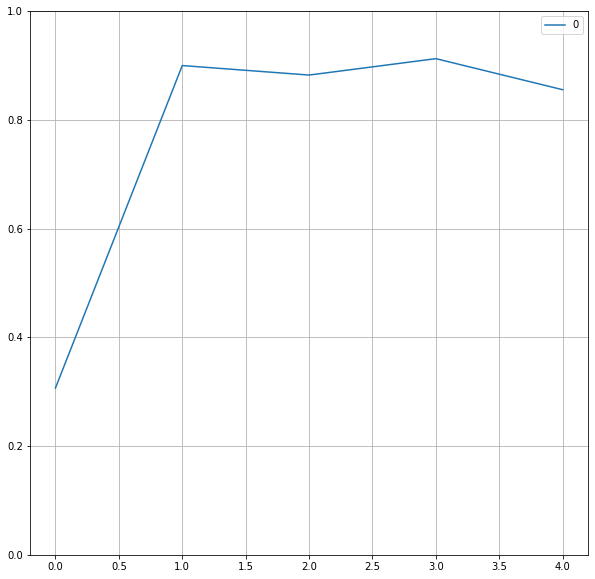

In [97]:
pd.DataFrame(eval).plot(figsize=(10, 10))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

### **VISULAIZING THE PREDICTION OF THE MODEL ON TESTING DATA**

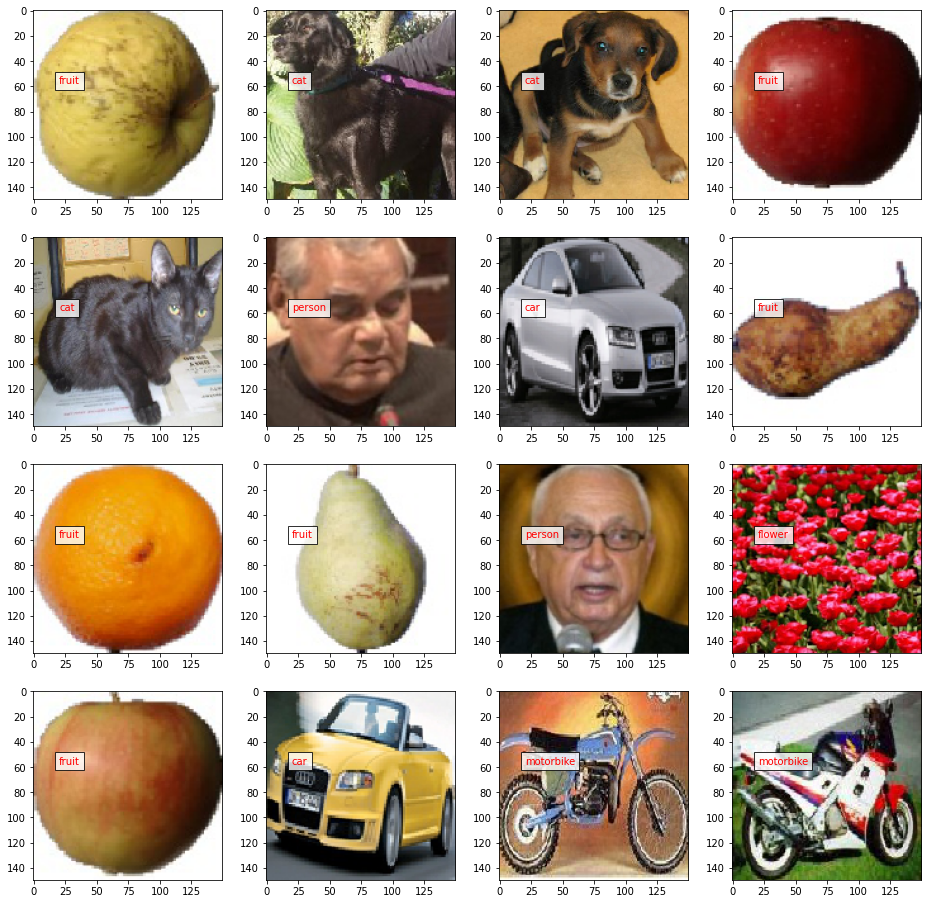

In [98]:
imgs, labels = next(test_generator)
fig=plt.figure(figsize=(16, 16))
columns = 4
rows = 4
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    img_t= np.expand_dims(imgs[i], axis=0)
    prediction = model.predict(img_t) 
    idx = prediction[0].tolist().index(max(prediction[0]))
    plt.text(20, 58,class_names[idx],color='red',fontsize=10,bbox=dict(facecolor='white',alpha=0.8))
    plt.imshow(imgs[i])
plt.savefig('model_pred.png')

## **III. TRANSFER LEARNING USING VGG16**

### **IMPORTING THE VGG 16 MODEL WEIGHTS for IMAGENET DATASET**

In [99]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

### **VGG16 ARCHITECTURE**

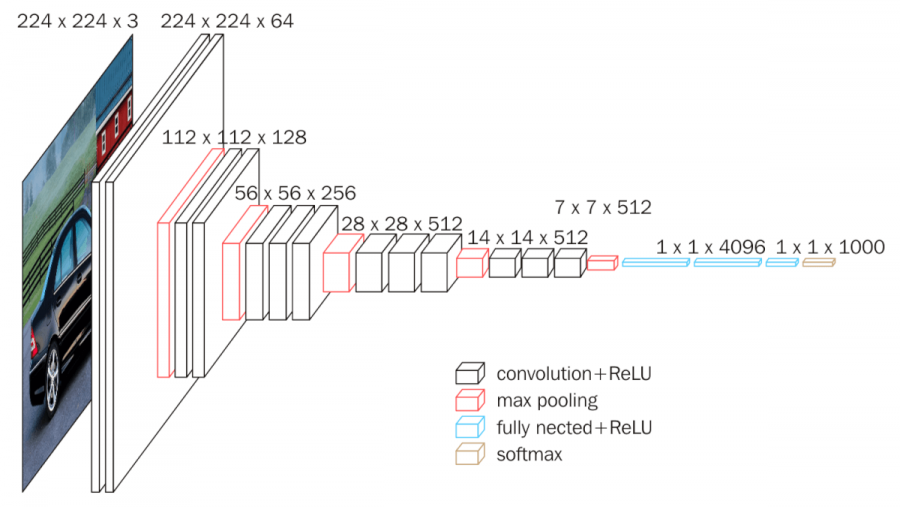

In [100]:
from IPython.core.display import Image, display
display(Image('https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png', width=700, unconfined=True))

In [101]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

### **ADDING LAYERS TO THE VGG 16 Architecture**

In [102]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(8, activation='softmax'))

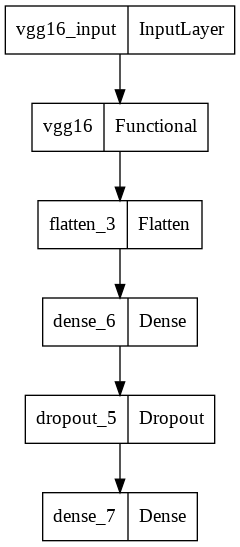

In [103]:
#Plotting a graphical representation of the model
import keras
import pydotplus
from tensorflow.keras.utils import plot_model
plot_model(model)

In [104]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               2097408   
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 16,814,152
Trainable params: 16,814,152
Non-trainable params: 0
_________________________________________________________________


In [105]:
from tensorflow.keras import optimizers
model.compile(
    loss='categorical_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5),
    metrics=['accuracy']  
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


### **TRAINING**

In [106]:
history_vbb = model.fit(
      train_generator,
      steps_per_epoch=100, 
      epochs=10,
      validation_data=val_generator,
      validation_steps=66)  

Epoch 1/10
100/100 [==============================] - 45s 430ms/step - loss: 1.1000 - accuracy: 0.6070 - val_loss: 0.1913 - val_accuracy: 0.9517
Epoch 2/10
100/100 [==============================] - 38s 377ms/step - loss: 0.3868 - accuracy: 0.8664
Epoch 3/10
100/100 [==============================] - 38s 376ms/step - loss: 0.2603 - accuracy: 0.9155
Epoch 4/10
100/100 [==============================] - 38s 376ms/step - loss: 0.1826 - accuracy: 0.9385
Epoch 5/10
100/100 [==============================] - 38s 376ms/step - loss: 0.1539 - accuracy: 0.9490
Epoch 6/10
100/100 [==============================] - 38s 376ms/step - loss: 0.1322 - accuracy: 0.9520
Epoch 7/10
100/100 [==============================] - 38s 376ms/step - loss: 0.1033 - accuracy: 0.9630
Epoch 8/10
100/100 [==============================] - 38s 376ms/step - loss: 0.1121 - accuracy: 0.9630
Epoch 9/10
100/100 [==============================] - 38s 376ms/step - loss: 0.1005 - accuracy: 0.9685
Epoch 10/10
100/100 [==========

In [107]:
model.save("model_vgg.h5") 

In [108]:
model = tf.keras.models.load_model('model_vgg.h5')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               2097408   
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 16,814,152
Trainable params: 16,814,152
Non-trainable params: 0
_________________________________________________________________


In [109]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

Found 1361 images belonging to 8 classes.


In [110]:
model.evaluate(test_generator, steps=9)

9/9 [==============================] - 3s 259ms/step - loss: 0.0102 - accuracy: 0.9944


[0.01022288203239441, 0.9944444298744202]

In [111]:
'''
from tensorflow.keras import optimizers
model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam',
    metrics=['accuracy']  
)

In [112]:
'''
history_vbb = model.fit(
      train_generator,
      steps_per_epoch=100, 
      epochs=10,
      validation_data=val_generator,
      validation_steps=66)  

Epoch 1/10
100/100 [==============================] - 42s 408ms/step - loss: 39.2345 - accuracy: 0.1400 - val_loss: 2.0745 - val_accuracy: 0.2131
Epoch 2/10
100/100 [==============================] - 35s 351ms/step - loss: 2.0740 - accuracy: 0.1470
Epoch 3/10
100/100 [==============================] - 35s 351ms/step - loss: 2.0746 - accuracy: 0.1325
Epoch 4/10
100/100 [==============================] - 35s 352ms/step - loss: 2.0717 - accuracy: 0.1540
Epoch 5/10
100/100 [==============================] - 35s 351ms/step - loss: 2.0717 - accuracy: 0.1426
Epoch 6/10
100/100 [==============================] - 35s 352ms/step - loss: 2.0751 - accuracy: 0.1385
Epoch 7/10
100/100 [==============================] - 35s 352ms/step - loss: 2.0731 - accuracy: 0.1486
Epoch 8/10
100/100 [==============================] - 35s 351ms/step - loss: 2.0741 - accuracy: 0.1480
Epoch 9/10
100/100 [==============================] - 35s 351ms/step - loss: 2.0724 - accuracy: 0.1340
Epoch 10/10
100/100 [=========

In [113]:
#model.save("model_vgg.h5") 

In [114]:
'''
model = tf.keras.models.load_model('model_vgg.h5')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               2097408   
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 16,814,152
Trainable params: 16,814,152
Non-trainable params: 0
_________________________________________________________________


In [115]:
'''
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

Found 1361 images belonging to 8 classes.


In [116]:
#model.evaluate(test_generator, steps=9)

9/9 [==============================] - 2s 224ms/step - loss: 2.0609 - accuracy: 0.1833


[2.0608887672424316, 0.18333333730697632]

### **VISULAIZING THE PREDICTION OF THE MODEL ON TESTING DATA**

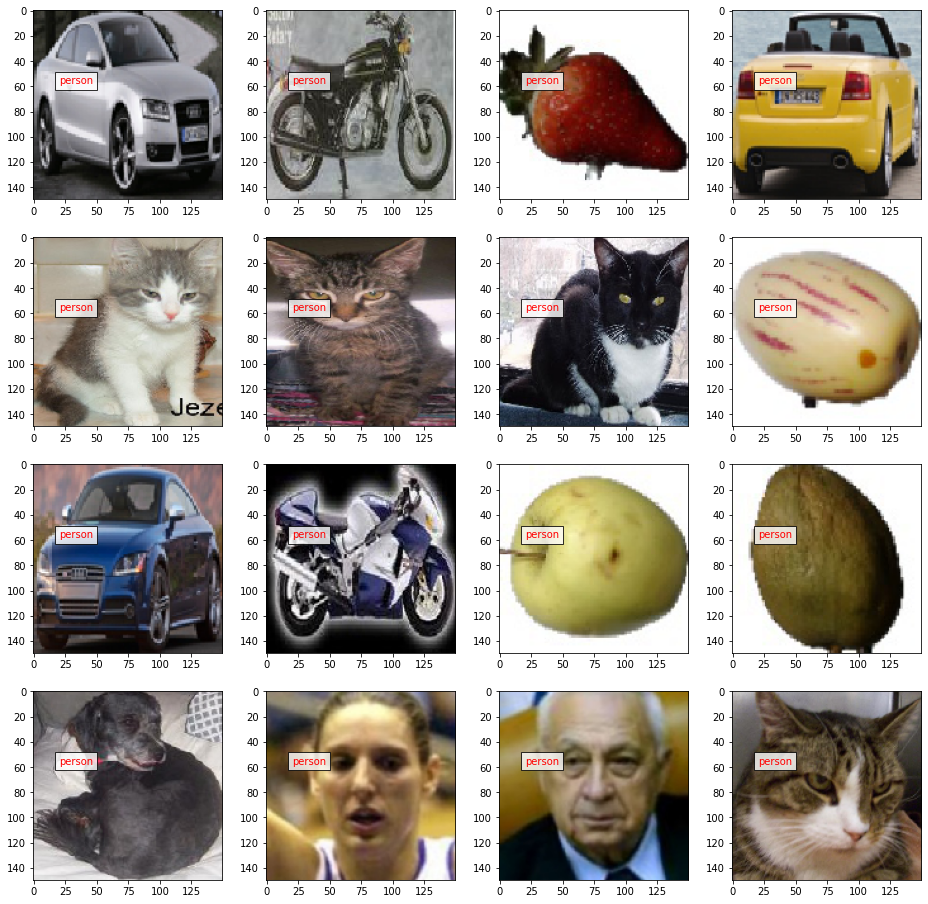

In [117]:
imgs, labels = next(test_generator)
fig=plt.figure(figsize=(16, 16))
columns = 4
rows = 4
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    img_t= np.expand_dims(imgs[i], axis=0)
    prediction = model.predict(img_t) 
    idx = prediction[0].tolist().index(max(prediction[0]))
    plt.text(20, 58,class_names[idx],color='red',fontsize=10,bbox=dict(facecolor='white',alpha=0.8))
    plt.imshow(imgs[i])
plt.savefig('vgg_pred')